# All analysis

In [1049]:
import numpy as np
import uproot
import uproot_methods
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplhep as hep
import re
from glob import glob
import iminuit
import probfit as pf

def my_style(title='', xtitle='', ytitle='', gridstyle=':'):
    plt.grid(linestyle=gridstyle)
    plt.title(title)
    plt.xlabel(xtitle)
    plt.ylabel(ytitle)
    
%matplotlib inline
import matplotlib
from jupyterthemes import jtplot
# jtplot.style(theme='monokai', context='talk', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
jtplot.style(theme='grade3', context='paper', ticks=True, grid=True, gridlines='--', figsize=(13, 9), fscale=2)
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans', 'sans-serif']

Get events number

In [362]:
%load_ext autoreload
%autoreload 2
from preparator import get_prepared_table

Get data

In [630]:
merge_points11 = [([887.5, 900., 912.5, 925., 935.], 910), ([945., 950., 962.5, 975., 987.5, 1000.], 950)]
merge_points12 = [([900, 920, 936], 920), ([950, 960, 970,], 950), ([ 980, 990], 960)] #12 year
merge_points17 = [([880., 890., 900.], 890), ([910., 920., 930.], 925),
           ([937.4, 937.5, 938.3, 938.9, 939.6, 940.2, 940.21, 940.8], 939)] #17 year
merge_points19 = [([862.5, 875.0, 887.5, 900.0], 874), ([912.5, 925.0, 936.0, 945.0], 912), ([950.0, 951.1, 955.0], 952), 
                  ([962.5, 975.0, 978.0, 987.5], 980)] #19 year

In [631]:
%ls ../../outputs/

11/  cross_sections/  mc17/          model_new_v7/      others/
12/  mc11/            mc17_uniform/  model_old_v6/      radcors_all.cpp
13/  mc11_uniform/    mc19/          model_old_v7/
17/  mc12/            mc19_uniform/  model_uniform_v6/
19/  mc12_uniform/    model_new_v6/  model_uniform_v7/


In [811]:
data = get_prepared_table('11', merge_points11, sys=False)
# data = get_prepared_table('mc19_uniform')

Data folder: ../../outputs/11/trees/*_*.root
dataRAW.shape: (3999, 6)
Checking: 40 different names in 11 season
Energy points with bad trigger:
 scan2011_tr_ph_fc_e525_v6.root      15
scan2011_tr_ph_fc_e537.5_v6.root     1
Name: name, dtype: int64
Bad energy records: 0
3932 records left
Records in  lum: 40
Records in data: 40
Differences in lum and data: set()
Good. 3933 rows
Merge energies
Good. 3933 rows
Good. 3933 rows


In [812]:
grouped_data = data.groupby('label')

## Fit data

In [813]:
def chi2ndf(bins):
    y0, x0 = np.histogram(dicx, bins=bins, range=(450, 550));
    x0 = (x0[:-1] + x0[1:])/2
    y0, x0 = y0[y0>0], x0[y0>0]
    y1 = pf.vector_apply(pdf, x0, *mt.values.values())*100/bins
    chi2 = np.sum( ((y1 - y0)**2)/y0 )
    ndf = len(x0) - len(mt.values.values())
    return chi2, ndf

In [814]:
data.head()

,name,mcname,label,mass,trigger,m2,Emean,lum,dEmin,dEmax
0,scan2011_tr_ph_fc_e1000_v6.root,tr_ph_kskl_1000_11333.root,950.0,496.517883,0,5.020700,970.748119,3052.256,24.05,31.56
1,scan2011_tr_ph_fc_e1000_v6.root,tr_ph_kskl_1000_11333.root,950.0,481.866150,0,-61.038792,970.748119,3052.256,24.05,31.56
2,scan2011_tr_ph_fc_e1000_v6.root,tr_ph_kskl_1000_11333.root,950.0,494.471771,0,-10.172338,970.748119,3052.256,24.05,31.56
3921,scan2011_tr_ph_fc_e945_v6.root,tr_ph_kskl_945_11608.root,950.0,498.798279,2,11.715331,970.748119,3052.256,24.05,31.56
3922,scan2011_tr_ph_fc_e950_v6.root,tr_ph_kskl_950_10902.root,950.0,508.760254,2,39.748701,970.748119,3052.256,24.05,31.56


In [815]:
dic = {}
for i in grouped_data.groups:
    print(i)
    dic[i] = np.array( grouped_data.get_group(i)['mass'] )

525.0
537.5
550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
650.0
662.5
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.5
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
875.0
910.0
950.0


In [816]:
#гаусс + гаусс + const
def gauss2(x, mu, dmu, sigma1, sigma2, f):
    return f*pf.gaussian(x, mu, sigma1) + (1-f)*pf.gaussian(x, mu+dmu, sigma2)
def const(x):
    return 1

mass_bound=(450,550)
norm_sig = pf.rename( pf.Normalized( gauss2, mass_bound ), ['x', 'M1','dM', 'S1', 'S2', 'f'] )
norm_bkg = pf.rename( pf.Normalized( const, mass_bound ), ['x'] )

ext_sig = pf.Extended(norm_sig, extname='N1')
ext_bkg = pf.Extended(norm_bkg, extname='N2')

pdf = pf.AddPdf(ext_sig, ext_bkg)
pf.describe(pdf)

['x', 'M1', 'dM', 'S1', 'S2', 'f', 'N1', 'N2']

In [817]:
# Mass
M1_lms = (497.80, 10.03)
dM_lms = (0.14, 4.0) #-0.31
S1_lms = (6, 6) #5.67
S2_lms = (10, 50.0) #9.98
f_lms = (0.6874, 0.5)

limits = {
    "limit_M1": [M1_lms[0]-M1_lms[1], M1_lms[0]+M1_lms[1]],
    "limit_S1": [S1_lms[0]-S1_lms[1], S1_lms[0]+S1_lms[1]],
    "limit_N1": [0, 100000],
    "limit_dM": [dM_lms[0]-dM_lms[1], dM_lms[0]+dM_lms[1]],
    "limit_S2": [S2_lms[0]-S2_lms[1], S2_lms[0]+S2_lms[1]],
    "limit_N2": [0, 7000],
    "limit_f": [f_lms[0]-f_lms[1], f_lms[0]+f_lms[1]],
}
errors = {
    "error_M1": 0.1,
    "error_S1": 0.01,
    "error_N1": 10,
    "error_dM": 0.,
    "error_S2": 0.,
    "error_N2": 1,
    "error_f": 0.,
}

In [818]:
def fitter(dic, nbins, energy, binnedLik=False):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M1": M1_lms[0], 
                          "dM": dM_lms[0], 
                          "S1": S1_lms[0], 
                          "S2": S2_lms[0],  
                          "f": f_lms[0],
                          "N1": np.size(dic), 
                          "N2": 1,
                         }
    mt = iminuit.Minuit(likelihood, **initial_par_values, **limits, **errors, pedantic=False)
    mt.migrad();
        
    likelihood.draw(minuit=mt, ) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    return mt, likelihood

In [819]:
itr = iter(dic)
fit_frame = pd.DataFrame(columns=[ 'M1', 'dM', 'S1', 'S2', 'f', 'Ns', 'Nb', 'M1_err', 'dM_err', 'S1_err', 'S2_err', 
                                  'f_err', 'Ns_err', 'Nb_err', 'energy'])

In [820]:
def limits_foo(M1, dM, S1, S2, f):
    M1 = M1 if isinstance(M1, tuple) else [M1, M1]
    dM = dM if isinstance(dM, tuple) else [dM, dM]
    S1 = S1 if isinstance(S1, tuple) else [S1, S1]
    S2 = S2 if isinstance(S2, tuple) else [S2, S2]
    f = f if isinstance(f, tuple) else [f, f]
    limits['limit_M1'] = M1 if M1 is not None else [M1_lms[0]-M1_lms[1], M1_lms[0]+M1_lms[1]]
    limits['limit_dM'] = dM if dM is not None else [dM_lms[0]-dM_lms[1], dM_lms[0]+dM_lms[1]]
    limits['limit_S1'] = S1 if S1 is not None else [S1_lms[0]-S1_lms[1], S1_lms[0]+S1_lms[1]]
    limits['limit_S2'] = S2 if S2 is not None else [S2_lms[0]-S2_lms[1], S2_lms[0]+S2_lms[1]]
    limits['limit_f']  =  f if  f is not None else [f_lms[0]-f_lms[1], f_lms[0]+f_lms[1]]

In [821]:
grouped_data.agg({'Emean': ['mean', 'std'], 'lum':'mean'}).iloc[:10]

Emean           lum
             mean  std     mean
label                          
525.0  523.580017  0.0  469.339
537.5  537.409973  0.0  554.231
550.0  548.440002  0.0  493.501
562.5  562.133972  0.0  549.094
575.0  575.309998  0.0  493.710
587.5  587.049988  0.0  522.721
600.0  598.036987  0.0  557.452
612.5  611.710022  0.0  536.375
625.0  622.469971  0.0  411.009
637.5  636.390015  0.0  458.156

In [921]:
i = next(itr)
print('Label:', i)

StopIteration: 

Migrad quality: True
Real: 15 Found: 15.002027444274258


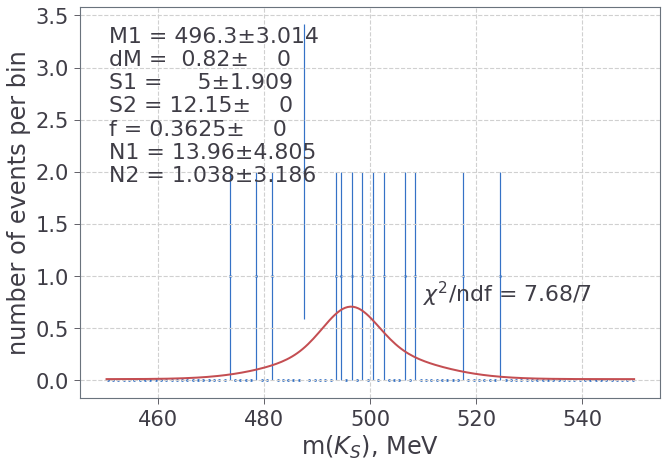

In [924]:
energy = i if type(i)!=str else float( re.findall(r"(\d+.?\d*)_", i)[0] )
# limits_foo(None, 5, 13.4, -190/(270 - float(i.split('_')[0]) ) + 0.10)
limits_foo(None, 0.82, (3, 10), 12.15, 1.322 - 1.01e-3*energy)
dicx = dic[i] #data.mass.values 
nbins = 100
mt, lik = fitter(dicx, nbins, i, False)
fit_frame.loc[i] = mt.values.values() + mt.errors.values() + [energy]
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['N1'] + mt.values['N2'] )

# vals = mt.values.values()
# vals[-2] *= 1-vals[-3]
# vals[-3] = 0
# pf.draw_pdf(pdf, arg=vals, bound=mass_bound, bins=nbins, density=False);
plt.text(510, 5*len(dicx)/nbins, f'$\\chi^2$/ndf = {chi2ndf(nbins)[0]:.2f}/{chi2ndf(nbins)[1]}')
# my_style(f'{i} MeV','Invariant mass, MeV','Number of events per bin','--')
my_style('','m($K_S$), MeV','number of events per bin','--')
# plt.savefig(f'../Journal/outputs/images/allan_19_{i}.pdf')

In [925]:
fit_frame.tail()

,M1,dM,S1,S2,f,Ns,Nb,M1_err,dM_err,S1_err,S2_err,f_err,Ns_err,Nb_err,energy
850.0,496.398222,0.82,4.770643,12.15,0.463500,22.144302,3.858832,1.954398,0.0,2.245786,0.0,0.0,5.252779,3.050901,850.0
862.5,491.371644,0.82,8.496331,12.15,0.450875,17.997108,0.000001,2.543338,0.0,3.012375,0.0,0.0,4.242124,1.088225,862.5
875.0,498.602095,0.82,4.796353,12.15,0.438250,11.700880,1.299343,2.357648,0.0,1.698760,0.0,0.0,3.524277,1.419703,875.0
910.0,494.087339,0.82,3.000000,12.15,0.402900,13.085732,1.919092,1.537349,0.0,1.343725,0.0,0.0,3.810943,1.830647,910.0
950.0,496.274836,0.82,5.000000,12.15,0.362500,13.963876,1.038151,3.013747,0.0,1.909375,0.0,0.0,4.804589,3.186217,950.0


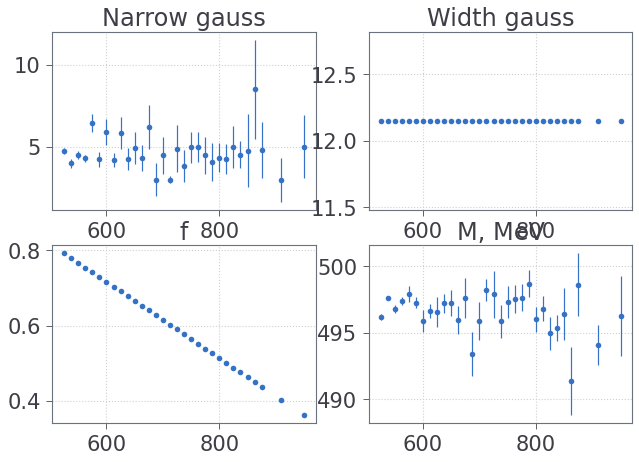

In [926]:
plt.subplot(221)
plt.errorbar(fit_frame.energy, fit_frame.S1, yerr=fit_frame.S1_err, fmt='o')
my_style('Narrow gauss')
plt.subplot(222)
plt.errorbar(fit_frame.energy, fit_frame.S2, yerr=fit_frame.S2_err, fmt='o')
my_style('Width gauss')
plt.subplot(223)
plt.errorbar(fit_frame.energy, fit_frame.f, yerr=fit_frame.f_err, fmt='o')
my_style('f')
plt.subplot(224)
dM = fit_frame.M1
dMerr = fit_frame.M1_err
plt.errorbar(fit_frame.energy, dM, yerr=dMerr, fmt='o')
my_style('M, MeV')
# plt.savefig('../Journal/outputs/images/allan_parameters_MCv7_v2_fixed.png')

In [861]:
def f(a, k): 
    return np.sum(((fit_frame.f-(k*fit_frame.energy + a))/fit_frame.f_err)**2)
#     return np.sum(((fit_frame.S2-a)/fit_frame.S2_err)**2)

m = iminuit.Minuit(f, a=-0.51, error_a=0.1, errordef=1, k=0, error_k=0.1)

In [289]:
m.migrad()

------------------------------------------------------------------
| FCN = 47.04                   |      Ncalls=38 (38 total)      |
| EDM = 2.44E-21 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | a    |   1.322   |   0.026   |            |            |         |         |       |
| 1 | k    | -1.01E-3  |  0.04E-3  |            |            |         |         |       |
------------------------------------------------------------------------------------------

In [794]:
mt.matrix(correlation=True)

------------------------------------
|    |     M1     S1     N1     N2 |
------------------------------------
| M1 |  1.000  0.000  0.000 -0.000 |
| S1 |  0.000  1.000 -0.000  0.000 |
| N1 |  0.000 -0.000  1.000 -0.000 |
| N2 | -0.000  0.000 -0.000  1.000 |
------------------------------------

Save fit_frame

In [927]:
# assert len(fit_frame) == len(data.drop_duplicates(subset=['name','lum']).set_index('name'))
fit_frame = fit_frame.join( data.drop_duplicates(subset=['name','lum']).set_index('label')\
                           [[ 'name', 'mcname', 'lum','dEmin','dEmax','Emean']] )

In [928]:
fit_frame.head()

,M1,dM,S1,S2,f,Ns,Nb,M1_err,dM_err,S1_err,...,f_err,Ns_err,Nb_err,energy,name,mcname,lum,dEmin,dEmax,Emean
525.0,496.197846,0.82,4.726156,12.15,0.791750,774.453347,10.525785,0.210944,0.0,0.181966,...,0.0,28.324221,6.188189,525.0,scan2011_tr_ph_fc_e525_v6.root,tr_ph_kskl_525_8997.root,469.339,0.0,0.0,523.580017
537.5,497.622016,0.82,4.000000,12.15,0.779125,888.904845,18.091665,0.170977,0.0,0.276744,...,0.0,30.196351,6.402688,537.5,scan2011_tr_ph_fc_e537.5_v6.root,tr_ph_kskl_537.5_13082.root,554.231,0.0,0.0,537.409973
550.0,496.811982,0.82,4.480610,12.15,0.766500,379.631418,8.456530,0.293101,0.0,0.249121,...,0.0,19.867253,4.845324,550.0,scan2011_tr_ph_fc_e550_v6.root,tr_ph_kskl_550_9158.root,493.501,0.0,0.0,548.440002
562.5,497.394377,0.82,4.284199,12.15,0.753875,399.258707,2.757855,0.278788,0.0,0.241564,...,0.0,20.182154,3.284490,562.5,scan2011_tr_ph_fc_e562.5_v6.root,tr_ph_kskl_562.5_12974.root,549.094,0.0,0.0,562.133972
575.0,497.902353,0.82,6.436239,12.15,0.741250,177.005219,0.000019,0.589232,0.0,0.556879,...,0.0,13.304407,1.284413,575.0,scan2011_tr_ph_fc_e575_v6.root,tr_ph_kskl_575_9288.root,493.710,0.0,0.0,575.309998


## Triggers

In [929]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

def triggers_table(data):
    triggers = data[['trigger','label']].set_index('label')
    triggers = triggers.assign(one = 1);
    triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='label', aggfunc=np.sum).fillna(0)
    triggers.columns = ['TF', 'CF', 'TC']
    triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
    triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
    triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

    triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
    triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
    triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                                  np.square((1-triggers['eCF'])*triggers['vTF']) )
    return triggers

In [930]:
triggers = triggers_table(data)

In [931]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
label,,,,,,,,,
525.0,303.0,340.0,142.0,0.295455,0.319911,0.520846,0.020717,0.022037,0.020966
537.5,509.0,19.0,379.0,0.950000,0.426966,0.971348,0.010884,0.016571,0.006291
550.0,228.0,59.0,101.0,0.629630,0.308157,0.743762,0.037824,0.025341,0.027800
562.5,226.0,11.0,165.0,0.932584,0.422392,0.961060,0.018741,0.024884,0.010954
575.0,105.0,25.0,47.0,0.648649,0.311688,0.758161,0.055125,0.037204,0.040131
587.5,102.0,3.0,71.0,0.947368,0.411429,0.969023,0.025447,0.037093,0.015104
600.0,43.0,24.0,27.0,0.528302,0.388889,0.711740,0.067932,0.057057,0.049475
612.5,72.0,2.0,47.0,0.941176,0.396694,0.964511,0.032629,0.044291,0.019857
625.0,32.0,3.0,11.0,0.750000,0.266667,0.816667,0.105021,0.065201,0.078721


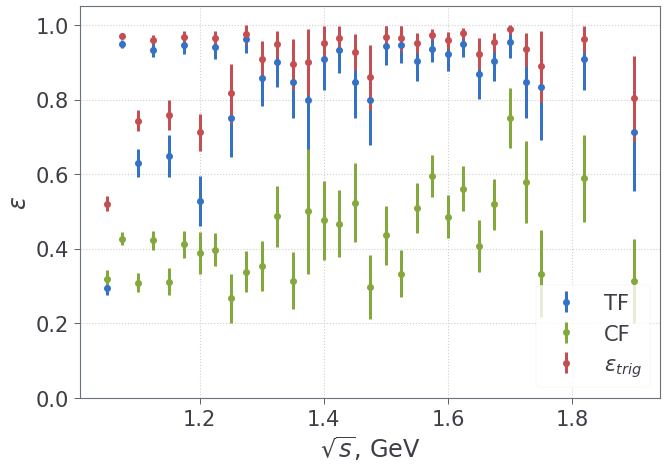

In [932]:
triggers['e'] = triggers.index
plt.errorbar( triggers.e*2e-3, triggers.eTF, yerr=triggers.vTF, fmt='o', label='TF', lw=3, ms=7 )
plt.errorbar( triggers.e*2e-3, triggers.eCF, yerr=triggers.vCF, fmt='o', label='CF', lw=3, ms=7 )
plt.errorbar( triggers.e*2e-3, triggers.TrigEff, yerr=triggers.TrigErr, fmt='o', label='$\\varepsilon_{trig}$', lw=3, ms=7 )
plt.legend(frameon=True)
plt.ylim(0, 1.05)
my_style('','$\\sqrt{s}$, GeV', '$\\varepsilon$')
# plt.savefig('../Journal/outputs/images/trig19.pdf')

In [933]:
fit_frame = fit_frame.join(triggers[['TrigEff','TrigErr']])

In [934]:
fit_frame.index = fit_frame.index.rename('label')

In [935]:
# fit_frame.to_csv('./data/fit_frame_11_2205.csv')

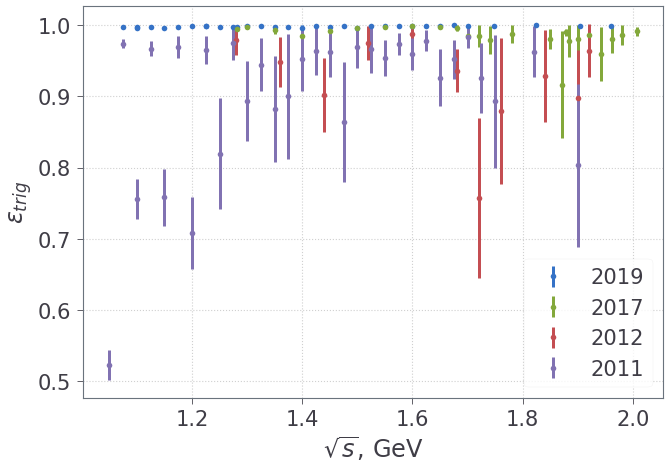

In [504]:
tr11 = pd.read_csv('./data/fit_frame_11_rotated.csv', index_col='name')[['TrigEff','TrigErr']]
tr12 = pd.read_csv('./data/fit_frame_12_rotated.csv', index_col='name')[['TrigEff','TrigErr']]
tr17 = pd.read_csv('./data/fit_frame_17_rotated.csv', index_col='name')[['TrigEff','TrigErr']]
tr19 = pd.read_csv('./data/fit_frame_19_rotated.csv', index_col='name')[['TrigEff','TrigErr']]
plt.errorbar(tr19.index*2e-3, tr19.TrigEff, yerr=tr19.TrigErr, fmt='o', lw=3, label='2019')
plt.errorbar(tr17.index*2e-3, tr17.TrigEff, yerr=tr17.TrigErr, fmt='o', lw=3, label='2017')
plt.errorbar(tr12.index*2e-3, tr12.TrigEff, yerr=tr12.TrigErr, fmt='o', lw=3, label='2012')
plt.errorbar(tr11.index*2e-3, tr11.TrigEff, yerr=tr11.TrigErr, fmt='o', lw=3, label='2011')
plt.legend(frameon=True);
my_style('','$\\sqrt{s}$, GeV', '$\\varepsilon_{trig}$')
# plt.savefig('../Journal/outputs/images/allan_triggers.pdf')

### Triggers covariation

In [269]:
triggers = data[['trigger','name']].set_index('name')
triggers = pd.get_dummies(triggers.trigger)
triggers[0] += triggers[2]
triggers[1] += triggers[2]
triggers.drop([2], axis=1, inplace=True)
triggers.columns = ['TF', 'CF']
triggers.head()

,TF,CF
name,,
537.5,1,1
537.5,1,1
537.5,1,1
537.5,1,1
537.5,1,0


In [270]:
np.cov( triggers.loc[550].values.T )

array([[ 0.0074401 , -0.00166209],
       [-0.00166209,  0.17269118]])

## Simultaneous fit

In [509]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [527]:
import lib
from lib import MDVM

In [1037]:
#neutral kaons
cs_n = [lib.get_KSKL_phi(), lib.get_KSKL_babar(), 
        lib.get_KSKL_up('./data/fit_frame_19_2205.csv', './data/rad_frame_19.csv'),
        lib.get_KSKL_up('./data/fit_frame_17_2205.csv', './data/rad_frame_17.csv'),
        lib.get_KSKL_up('./data/fit_frame_12_2205.csv', './data/rad_frame_12.csv'),
        lib.get_KSKL_up('./data/fit_frame_11_2205.csv', './data/rad_frame_11.csv'),
#         lib.get_KSKL_up('./data/fit_frame_13_rotated.csv', './data/rad_frame_v6_rotated2.csv'),
       ] 
#charged kaons
cs_c = [lib.get_KPKM_phi(), lib.get_KPKM_up2(), lib.get_KPKM_up()]

In [805]:
cs_n[2].head()

,energy,energy_err_min,energy_err_max,cs,cs_err,rad
0,1.074908,0.0,0.0,7.239565,0.205073,0.217469
1,1.098682,0.0,0.0,4.287084,0.140338,0.215185
2,1.099346,0.0,0.0,3.950052,0.209339,0.209847
3,1.124995,0.0,0.0,2.606683,0.110989,0.235544
4,1.149712,0.0,0.0,2.059221,0.099328,0.238559


In [1253]:
ndf = len(cs_n[0])+len(cs_n[2])+len(cs_n[3])+len(cs_n[4])+len(cs_n[5])+len(cs_c[0])+len(cs_c[1])+len(cs_c[2])
ndf

229

In [941]:
A = MDVM()

In [1308]:
max_e = 4
min_e = 0.4
def least_squares(par):
    chisq = 0
    p = par
    for c in np.array(cs_n)[[0,2,3,4,5]]: #0,2,3,4,5
        chisq += np.square( (c.cs - A.Cross_Section_Neutral(c.energy, par))/c.cs_err )[(c.energy<max_e)&(c.energy>min_e)].sum()
    for c in cs_c:
        chisq += np.square( (c.cs - A.Cross_Section_Charged(c.energy, par))/c.cs_err )[(c.energy<max_e)&(c.energy>min_e)].sum()
    e1 = abs( 1 - ( p[1] + p[4] + p[7] + p[10] ) - (p[0] - 1)*p[3]/3 )*1e3
    e2 = abs( 3 - ( p[2] + p[5] + p[8] + p[11] + 2 * ( p[3] + p[6] + p[9] ) ) )*1e3/3
    chisq += (e1 + e2)
#     print( e1, e2 )
    return chisq

In [1309]:
least_squares(params)

582.5723197074853

In [1292]:
names = ['$\\rho\'\'$', '$\\omega\'\'$', '$\\phi\'\'$', 'M($\\rho\'\'\'$)', 'W($\\rho\'\'\'$)','M($\\rho4$)', 'W($\\rho4$)', 
         'M($\\omega\'\'$)','W($\\omega\'\'$)', 'M($\\phi\'\'$)', 'W($\\phi\'\'$)' ]
#     '$\\rho$', '$\\omega$', '$\\phi$', '$\\rho\'$', '$\\omega\'$', 
#          '$\\phi\'$', '$\\rho\'\'$', '$\\omega\'\'$', '$\\eta$', 
#          'M($\\omega\'$)', 'W($\\omega\'$)', 'M($\\omega\'\'$)', 'W($\\omega\'\'$)', 'M($\\phi\'\'$)', 'W($\\phi\'\'$)']
#          '$\\rho^{(3)}$', '$\\rho^{(4)}$', '$\\phi\'\'$',  'M($\\phi\'$)', 'W($\\phi\'$)', 
#          'M($\\phi\'\'$)', 'W($\\phi\'\'$)', 'W($\\rho^{(3)}$)', 'W($\\rho^{(4)}$)', 'a', 'b']
# params = [0.9802, 1.1787, 1.1659, 1.0397, -0.0699, -0.0841, -0.1617, -0.0851, -0.1474, 0.0151, 0.0334, 0.2793, 1515.0, 248.7102, 1449.0932, 280.1714, 1671.4159, 181.8241, 1700.0, 449.9986, 1610.0001, 366.2361, 1958.3253, 219.2568, 1996.7143, 336.7568, 2210.1137, 107.5767]
# params = [0.9922, 1.3123, 1.4888, 1.0348, -0.0645, -0.1378, -0.1952, -0.0854, -0.1728, 0.0096, 0.0837, 0.1752, 1515.0, 287.3592, 1448.2196, 350.0, 1675.2645, 231.9669, 1737.2471, 450.0, 1610.0, 384.9999, 1961.5127, 307.294, 1936.664, 301.8949, 2202.9414, 79.4786]
params = [0.9821, 1.114, 1.3662, 1.0418, -0.0909, -0.1708, -0.1616, -0.0637, -0.1846, 0.0145, 0.0468, 0.1999, 1489.9999, 340.0067, 1439.0646, 249.9999, 1660.0388, 199.938, 1700.0128, 349.9998, 1640.0005, 349.9968, 1963.3063, 215.3234, 2017.8655, 302.2497, 2208.453, 102.3458]
fix_pars = [False, False, False, False, False, False, False, False, False, False, False, False,
           False, False, False, False, False, False, False, False, False, False, False, False,
           False, False, False, False] # True False
error_pars = 0.01*np.array(params)

In [1293]:
len(names), len(params), len(fix_pars)

(11, 28, 28)

In [1294]:
limit_pars = [(0.98, 1.02), (1, 2), (0.8, 2), (1, 2), 
              (-.5, .5), (-1.05, 1.05), (-.5, .5), (-.5, .5), (-1.05, 1.05), (-.5, .5), (-.5,.5), (-.5,.5), 
              (1465-25,1465+25), (400-60,400+60), 
              (1400,1450), (180,250), 
              (1680-20,1680+20), (150-50,150+50), 
              (1720-20,1720+20), (250-100,250+100),
              (1670-30,1670+30), (315-35,315+35),
              (1900,2300), (100,500),
              (1900,2300), (100,500),
              (2100,2250), (60,295),
             ]

In [1298]:
m = iminuit.Minuit.from_array_func(least_squares, params, fix=fix_pars, \
                                   error=error_pars, errordef=1, limit=limit_pars)#, name=names, 
m.get_param_states()

------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.983   |   0.010   |            |            |  0.98   |  1.02   |       |
| 1 | x1   |   1.115   |   0.011   |            |            |    1    |    2    |       |
| 2 | x2   |   1.398   |   0.014   |            |            |   0.8   |    2    |       |
| 3 | x3   |   1.040   |   0.010   |            |            |    1    |    2    |       |
| 4 | x4   | -0.911E-1 | -0.009E-1 |            |            |  -0.5   |   0.5   |       |
| 5 | x5   | -1.880E-1 | -0.019E-1 |            |            |  -1.05  |  1.05   |       |
| 6 | x6   | -2.028E-1 | -0.020E-1 |            |            |  -0.5   |   0.5   |       |
| 7 | x7   | -0.747E-1 | -0.007E-1 |            |            |  -0.5   |   0.5   |       |
| 8 | x8   | -1.156E-1 | -0.012E-1 |            |            |  -1.05  |  1.05   |       |
| 9 | x9   | 1.120E-2  | 0.011E-2  |            |            |  -0.5   |   0.5   |       |
| 10| x10  | 0.572E-1  | 0.006E-1  |            |            |  -0.5   |   0.5   |       |
| 11| x11  | 2.076E-1  | 0.021E-1  |            |            |  -0.5   |   0.5   |       |
| 12| x12  |   1490    |    15     |            |            |  1440   |  1490   |       |
| 13| x13  |    365    |     4     |            |            |   340   |   460   |       |
| 14| x14  |   1450    |    15     |            |            |  1400   |  1450   |       |
| 15| x15  |    250    |     3     |            |            |   180   |   250   |       |
| 16| x16  |   1672    |    17     |            |            |  1660   |  1700   |       |
| 17| x17  |   200.0   |    2.3    |            |            |   100   |   200   |       |
| 18| x18  |   1700    |    17     |            |            |  1700   |  1740   |       |
| 19| x19  |    350    |     4     |            |            |   150   |   350   |       |
| 20| x20  |   1640    |    16     |            |            |  1640   |  1700   |       |
| 21| x21  |    350    |     4     |            |            |   280   |   350   |       |
| 22| x22  |   1953    |    20     |            |            |  1900   |  2300   |       |
| 23| x23  |   220.9   |    2.2    |            |            |   100   |   500   |       |
| 24| x24  |   2003    |    20     |            |            |  1900   |  2300   |       |
| 25| x25  |    357    |     4     |            |            |   100   |   500   |       |
| 26| x26  |   2205    |    22     |            |            |  2100   |  2250   |       |
| 27| x27  |   87.0    |    0.9    |            |            |   60    |   295   |       |
------------------------------------------------------------------------------------------

In [1299]:
m.migrad()

------------------------------------------------------------------
| FCN = 582.6                   |   Ncalls=11248 (11259 total)   |
| EDM = 9.2E+03 (Goal: 1E-05)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   False   |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | x0   |   0.982   |   0.020   |            |            |  0.98   |  1.02   |       |
| 1 | x1   |   1.114   |   0.014   |            |            |    1    |    2    |       |
| 2 | x2   |   1.37    |   0.10    |            |            |   0.8   |    2    |       |
| 3 | x3   |   1.04    |   0.19    |            |            |    1    |    2    |       |
| 4 | x4   |   -0.09   |    0.17   |            |            |  -0.5   |   0.5   |       |
| 5 | x5   |   -0.17   |    0.63   |            |            |  -1.05  |  1.05   |       |
| 6 | x6   |   -0.16   |    0.20   |            |            |  -0.5   |   0.5   |       |
| 7 | x7   |   -0.06   |    0.28   |            |            |  -0.5   |   0.5   |       |
| 8 | x8   |   -0.18   |    0.68   |            |            |  -1.05  |  1.05   |       |
| 9 | x9   |   0.015   |   0.059   |            |            |  -0.5   |   0.5   |       |
| 10| x10  |   0.05    |   0.14    |            |            |  -0.5   |   0.5   |       |
| 11| x11  |   0.20    |   0.28    |            |            |  -0.5   |   0.5   |       |
| 12| x12  |   1490    |    31     |            |            |  1440   |  1490   |       |
| 13| x13  |    340    |    70     |            |            |   340   |   460   |       |
| 14| x14  |   1440    |    40     |            |            |  1400   |  1450   |       |
| 15| x15  |    250    |    40     |            |            |   180   |   250   |       |
| 16| x16  |   1660    |    25     |            |            |  1660   |  1700   |       |
| 17| x17  |    200    |    60     |            |            |   100   |   200   |       |
| 18| x18  |   1700    |    25     |            |            |  1700   |  1740   |       |
| 19| x19  |    350    |    120    |            |            |   150   |   350   |       |
| 20| x20  |   1640    |    40     |            |            |  1640   |  1700   |       |
| 21| x21  |    350    |    40     |            |            |   280   |   350   |       |
| 22| x22  |   1960    |    120    |            |            |  1900   |  2300   |       |
| 23| x23  |    220    |    150    |            |            |   100   |   500   |       |
| 24| x24  |   2020    |    150    |            |            |  1900   |  2300   |       |
| 25| x25  |    300    |    170    |            |            |   100   |   500   |       |
| 26| x26  |   2210    |    60     |            |            |  2100   |  2250   |       |
| 27| x27  |    100    |    80     |            |            |   60    |   295   |       |
------------------------------------------------------------------------------------------

In [1311]:
# m.matrix(correlation=True)

In [1301]:
print('params =', list(m.np_values().round(4)) )

params = [0.9821, 1.114, 1.3662, 1.0418, -0.0909, -0.1708, -0.1616, -0.0637, -0.1846, 0.0145, 0.0468, 0.1999, 1489.9999, 340.0067, 1439.0646, 249.9999, 1660.0388, 199.938, 1700.0128, 349.9998, 1640.0005, 349.9968, 1963.3063, 215.3234, 2017.8655, 302.2497, 2208.453, 102.3458]


In [1302]:
params = m.np_values()

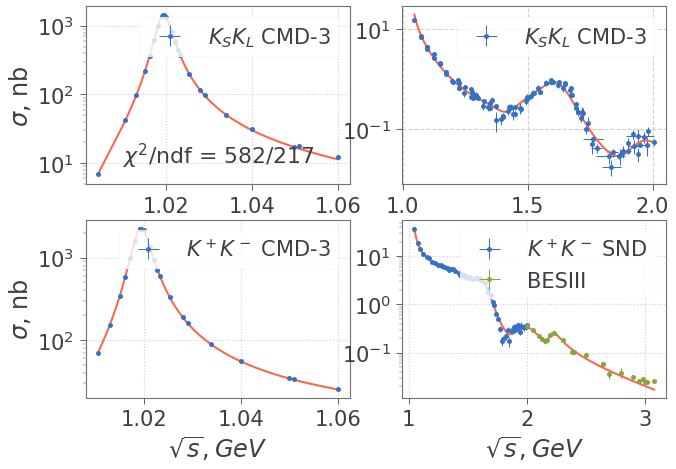

In [1326]:
plt.subplot(221)
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[0]], ['$K_SK_L$ CMD-3'])
plt.text(1.01, 10, '$\chi^2$/ndf = 582/217')
my_style('','', '$\sigma$, nb')

plt.subplot(222)
lib.plot_cs(A.Cross_Section_Neutral, params, [pd.concat(cs for cs in cs_n[2:])], ['$K_SK_L$ CMD-3'])

plt.subplot(223)
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[0]], ['$K^+K^-$ CMD-3'])
my_style('','$\sqrt{s}, GeV$', '$\sigma$, nb')

plt.subplot(224)
lib.plot_cs(A.Cross_Section_Charged, params, [cs_c[2], cs_c[1]], ['$K^+K^-$ SND', 'BESIII'])
my_style('','$\sqrt{s}, GeV$', '')
# plt.savefig('../Journal/outputs/images/sim_fit.pdf')

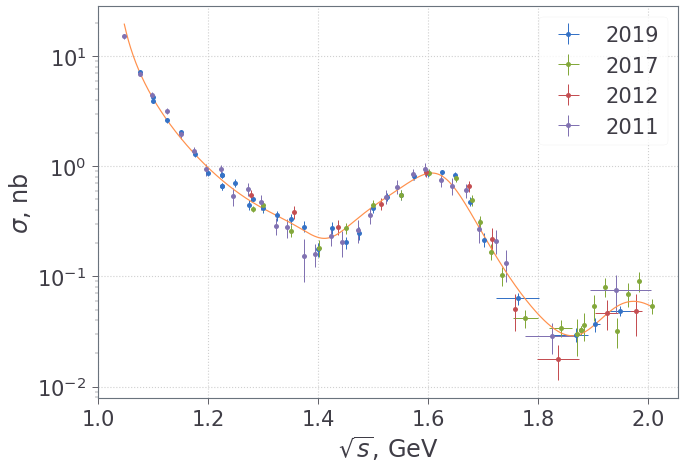

In [1304]:
lib.plot_cs(A.Cross_Section_Neutral, params, [cs_n[2], cs_n[3], cs_n[4], cs_n[5]],
            ['2019','2017', '2012', '2011'])# '2013'])
my_style('','$\sqrt{s}$, GeV', '$\sigma$, nb')
# plt.text(1.05, 2e-2, '$\chi^2$/ndf = 173.9/116')
# plt.savefig('../Journal/outputs/images/sec_fit2.pdf')

In [336]:
# lib.plot_cs(None, None, [cs_n[1], cs_n[2], cs_n[3]], ['babar','2019','2017'])

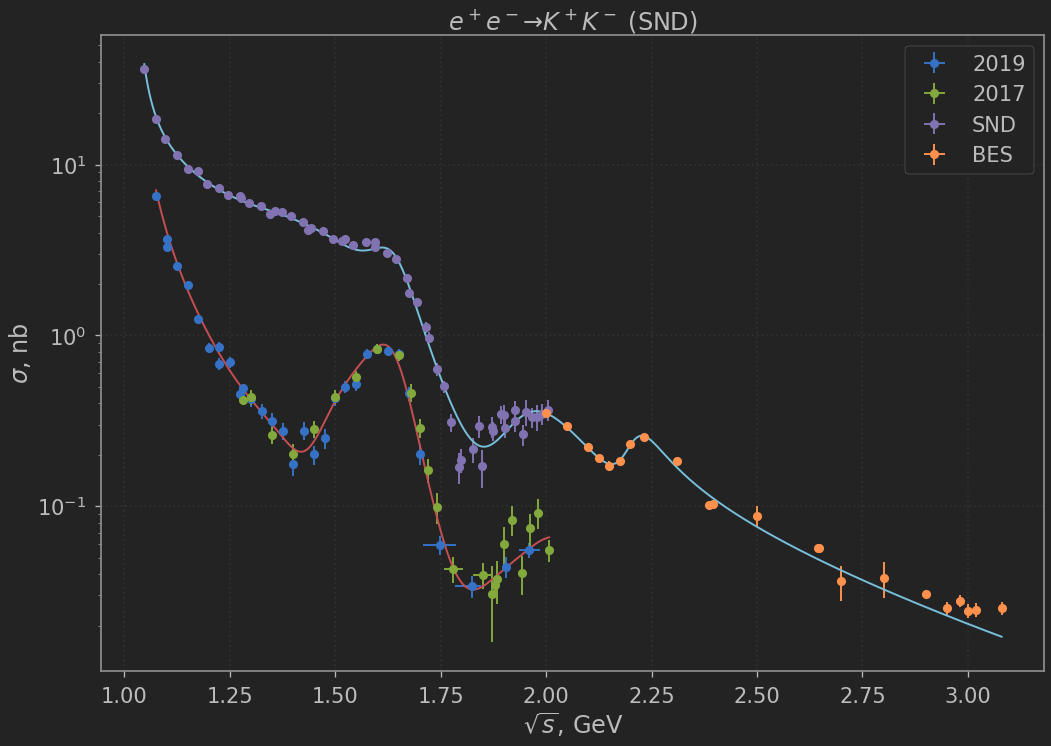

In [19]:
# plt.figure(figsize=(9,5))
lib.plot_cs(A.Cross_Section_Neutral, params, [ cs_n[2], cs_n[3] ], ['2019', '2017'])
# plt.xlim(1.1, 2);
my_style('$e^+e^- \\to KSKL$','', '$\\sigma$, nb')

# plt.subplot(212)
lib.plot_cs(A.Cross_Section_Charged, params, [ cs_c[2], cs_c[1] ], ['SND', 'BES'])
my_style('$e^+e^- \\to K^+K^-$ (SND)', '$\\sqrt{s}$, GeV', '$\\sigma$, nb')

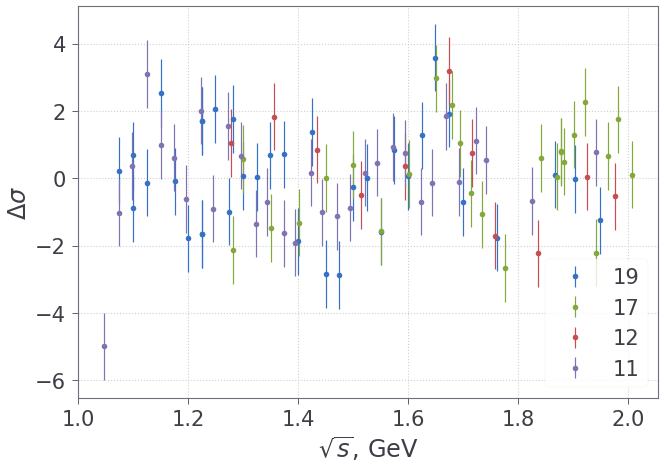

In [1312]:
def plot_resid(cs, foo, label):
    plt.errorbar(cs.energy, (cs.cs - foo(cs.energy, params))/cs['cs_err'], yerr=1, fmt='o', label=label)

plot_resid(cs_n[2], A.Cross_Section_Neutral, '19')
plot_resid(cs_n[3], A.Cross_Section_Neutral, '17')
plot_resid(cs_n[4], A.Cross_Section_Neutral, '12')
plot_resid(cs_n[5], A.Cross_Section_Neutral, '11')
# plot_resid(cs_c[2], A.Cross_Section_Charged, 'SND')
# plot_resid(cs_c[1], A.Cross_Section_Charged, 'BES')
# plot_resid(cs_n[0], A.Cross_Section_Neutral, 'CMD')
# plot_resid(cs_c[0], A.Cross_Section_Charged, 'CMD')
plt.legend()
my_style('', '$\sqrt{s}$, GeV', '$\Delta \sigma$')
# plt.savefig('../Journal/outputs/images/sec_dev.png', dpi=200)

In [1052]:
from ipywidgets import interact_manual, interact

def plotcs(r3, r4):
    # plt.subplot(211)
    params2 = params.copy()
    params2[9], params2[10] = r3, r4
    plt.figure(figsize=(9,5))
    lib.plot_cs(A.Cross_Section_Neutral, params2, [ cs_n[2], cs_n[3] ], ['2019', '2017'])
    # plt.xlim(1.1, 2);
    my_style('$e^+e^- \\to KSKL$','', '$\\sigma$, nb')

    # plt.subplot(212)
    lib.plot_cs(A.Cross_Section_Charged, params2, [ cs_c[2], cs_c[1] ], ['SND', 'BES'])
    my_style('$e^+e^- \\to K^+K^-$ (SND)', '$\\sqrt{s}$, GeV', '$\\sigma$, nb')
    
p1, p2 = abs(params[9]), abs(params[10])
interact(plotcs, r3=(-2*p1,2*p1,p1/20), r4=(-2*p2,2*p2,p2/20));

interactive(children=(FloatSlider(value=-3.469446951953614e-18, description='r3', max=0.02718841895790172, min…

In [1122]:
x = np.linspace(0.48*2, 2., 1000)
y = A.Cross_Section_Neutral(x, params)

## Radiative corrections

In [975]:
from lib import PhotonEff, RadCor

In [1123]:
year = 19
g = glob(f'../../outputs/mc{year}_uniform/trees/*.root')
g.extend(glob(f'../../outputs/mc{year}/trees/*.root'))

In [1124]:
p = PhotonEff()
p.open(*g, min_entries=1000)

In [1125]:
p.get_histos();
p.fit_histos();

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [1100]:
# p.show_histo_by_name('tr_ph_kskl_980_16189.root')
# plt.savefig('../Journal/outputs/images/allan_effreg_640_v6.pdf', dpi=150)

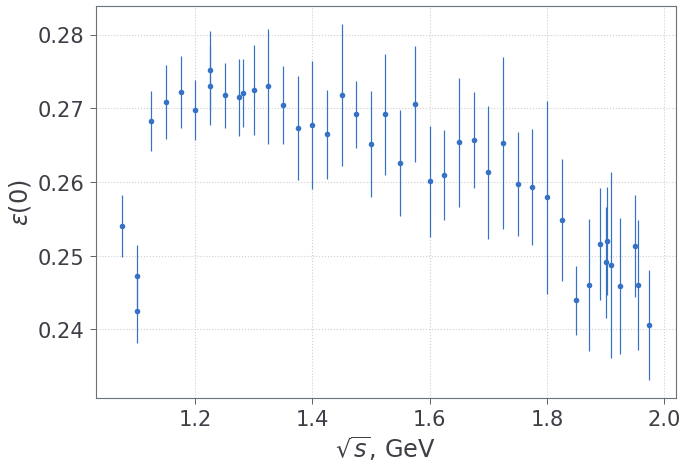

In [1126]:
es, effs, errs = list(), list(), list()
for e in p.fit_results:
    eff = p.sigFunc(0, *p.fit_results[e][0])
    err1 = p.sigFunc(0, *(p.fit_results[e][0]+p.fit_results[e][1])) - eff
    err2 = eff - p.sigFunc(0, *(p.fit_results[e][0]-p.fit_results[e][1]))
    effs.append(eff)
    errs.append(err1)
    es.append(float(re.findall(r'_(\d+.?\d*)_',e)[0]))
plt.errorbar(np.array(es)*2e-3, effs, yerr=errs, fmt='o')
# plt.errorbar(np.array(es2)*2e-3, effs2, yerr=errs2, fmt='o')
my_style('','$\sqrt{s}$, GeV', '$\\varepsilon(0)$')
eff_frame = pd.DataFrame({'name':es, 'eff':effs, 'err':errs})

In [1102]:
def parametrizator(i=4):
    def chi2_parametrizator(k, b):
        return np.sum(((yp - (k*xe+b))/yperr)**2)
    #mu, s, c, N
    chindf_mean = 0
    xe = list()
    yp = list()
    yperr = list()
    for e in p.fit_results:
        chindf_mean += p.fit_results[e][2]/p.fit_results[e][3]
        if p.good_fits[e] == False:
            print('Bad fit at', e)
            continue
        xe.append(float(re.findall(r'_(\d+.?\d*)_',e)[0])*2e-3)
        yp.append(p.fit_results[e][0][i])
        yperr.append(p.fit_results[e][1][i])
    xe, yp, yperr = np.array(xe), np.array(yp), np.array(yperr)
    print('Chi2/ndf mean:', chindf_mean/len(xe))
    plt.errorbar(xe, yp, yperr, fmt='o')
    m = iminuit.Minuit(chi2_parametrizator, pedantic=False)
    print( m.migrad() )
    k, b = m.np_values()
    plt.plot([xe.min(), xe.max()], [k*xe.min()+b, k*xe.max()+b])
    return

In [1103]:
# parametrizator(0)

In [1127]:
r = RadCor()

In [1128]:
xen, xrad, xlb = list(), list(), list()
effs, errs = list(), list()
for en in p.fit_results:
    ps = p.fit_results[en][0]
    res = r.F_Radcor(x*5e2, y, float(re.findall(r'_(\d+.?\d*)_', en)[0]), ps, 1) 
#     print( 'Energy:', en, 'Rad:', res[0])
    xen.append(float(re.findall(r'_(\d+.?\d*)_', en)[0]))
    xlb.append(en)
    xrad.append(res[0])
rad_frame = pd.DataFrame({'name':xen, 'mcname':xlb, 'rad': xrad}).sort_values(by='name')

In [1129]:
assert len(rad_frame) == len(eff_frame)
rad_frame = rad_frame.set_index('name').join(eff_frame.set_index('name')).reset_index()

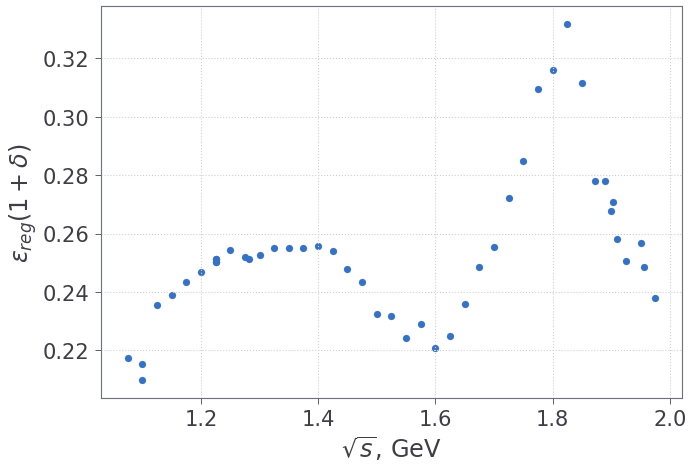

In [1154]:
plt.scatter(rad_frame.name*2e-3, rad_frame.rad, s=50)
my_style('','$\sqrt{s}$, GeV', '$\\varepsilon_{reg}(1+\delta)$')
# plt.savefig('../Journal/outputs/images/allan_effregradcor.pdf')

In [1108]:
rad_frame.tail()

,name,mcname,rad,eff,err
35,950.0,tr_ph_kskl_950_10902.root,0.129550,0.081572,0.003993
36,962.5,tr_ph_kskl_962.5_10992.root,0.114707,0.080555,0.004414
37,975.0,tr_ph_kskl_975_11110.root,0.098323,0.072048,0.004461
38,987.5,tr_ph_kskl_987.5_11220.root,0.089626,0.064703,0.004265
39,1000.0,tr_ph_kskl_1000_11333.root,0.081778,0.053739,0.003104


In [1110]:
# rad_frame.to_csv(f'./data/rad_frame_{year}.csv', index=False)

In [1135]:
rad_frame_v7 = pd.read_csv('./data/rad_frame_19.csv')
rad_frame_v6 = pd.read_csv('./data/rad_frame_17.csv')
rad_frame_v5 = pd.read_csv('./data/rad_frame_12.csv')
rad_frame_v4 = pd.read_csv('./data/rad_frame_11.csv')

In [733]:
rad_frame_v7.head()

,name,mcname,rad,eff,err
0,537.5,tr_ph_kskl_537.5_70914.root,0.217469,0.254022,0.004224
1,550.0,tr_ph_kskl_550_70260.root,0.215185,0.247275,0.004188
2,550.1,tr_ph_kskl_550.1_70029.root,0.209847,0.242552,0.004365
3,562.5,tr_ph_kskl_562.5_71178.root,0.235544,0.268272,0.004106
4,575.0,tr_ph_kskl_575_71544.root,0.238559,0.270810,0.005014


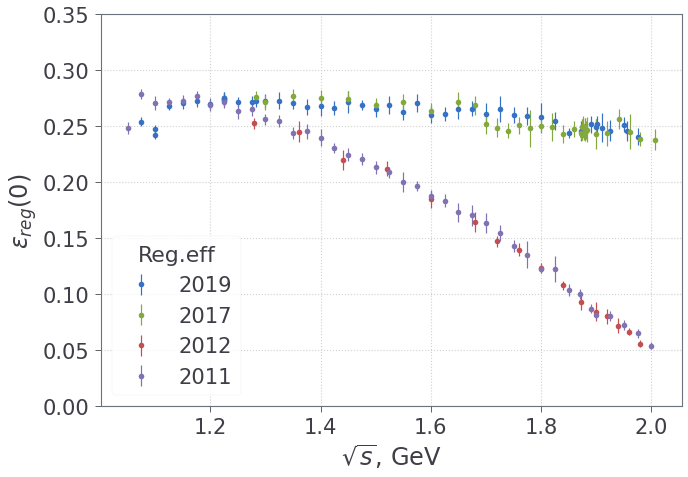

In [754]:
plt.errorbar(rad_frame_v7.name*2e-3, rad_frame_v7.eff, yerr=rad_frame_v7.err, fmt='o', label='2019')
plt.errorbar(rad_frame_v6.name*2e-3, rad_frame_v6.eff, yerr=rad_frame_v6.err, fmt='o', label='2017')
plt.errorbar(rad_frame_v5.name*2e-3, rad_frame_v5.eff, yerr=rad_frame_v5.err, fmt='o', label='2012')
plt.errorbar(rad_frame_v4.name*2e-3, rad_frame_v4.eff, yerr=rad_frame_v4.err, fmt='o', label='2011')
plt.legend(title='Reg.eff')
my_style('','$\sqrt{s}$, GeV', '$\\varepsilon_{reg}(0)$')
plt.ylim(0, 0.35);
# plt.savefig('../Journal/outputs/images/allan_regeff.png')

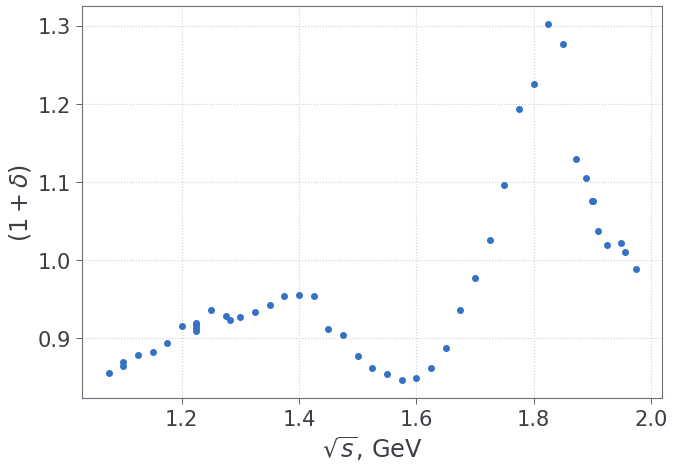

In [1159]:
plt.errorbar(rad_frame_v7.name*2e-3, rad_frame_v7.rad/rad_frame_v7.eff, fmt='o', ms=7)#, label='2017/19')
# plt.errorbar(rad_frame_v6.name*2e-3, rad_frame_v6.rad/rad_frame_v6.eff, fmt='o', label='2011/12')
# plt.errorbar(rad_frame_v5.name*2e-3, rad_frame_v5.rad/rad_frame_v5.eff, fmt='o', label='2011/12')
# plt.errorbar(rad_frame_v4.name*2e-3, rad_frame_v4.rad/rad_frame_v4.eff, fmt='o', label='2011/12')
# plt.legend()
my_style('','$\sqrt{s}$, GeV', '$(1+\\delta)$')
# plt.ylim(0, 0.35);
# plt.savefig('../Journal/outputs/images/allan_radcor.pdf')